# Project 3: Poisonous Mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 examples, where each describes a mushroom by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. The feature space has been binarized. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using k-means and density estimation with Gaussian mixture models (GMM). Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please **prepare your own write-up and write your own code**.

In [130]:
%matplotlib inline

import urllib.request as urllib2 # For python3
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
import sklearn

In [131]:
MUSHROOM_DATA = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.data'
MUSHROOM_MAP = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.map'

Load feature names.

In [132]:
feature_names = []

for line in urllib2.urlopen(MUSHROOM_MAP):
    [index, name, junk] = line.decode('utf-8').split()
    feature_names.append(name)

print('Loaded feature names: ', len(feature_names))
print(feature_names)

Loaded feature names:  126
['cap-shape=bell', 'cap-shape=conical', 'cap-shape=convex', 'cap-shape=flat', 'cap-shape=knobbed', 'cap-shape=sunken', 'cap-surface=fibrous', 'cap-surface=grooves', 'cap-surface=scaly', 'cap-surface=smooth', 'cap-color=brown', 'cap-color=buff', 'cap-color=cinnamon', 'cap-color=gray', 'cap-color=green', 'cap-color=pink', 'cap-color=purple', 'cap-color=red', 'cap-color=white', 'cap-color=yellow', 'bruises?=bruises', 'bruises?=no', 'odor=almond', 'odor=anise', 'odor=creosote', 'odor=fishy', 'odor=foul', 'odor=musty', 'odor=none', 'odor=pungent', 'odor=spicy', 'gill-attachment=attached', 'gill-attachment=descending', 'gill-attachment=free', 'gill-attachment=notched', 'gill-spacing=close', 'gill-spacing=crowded', 'gill-spacing=distant', 'gill-size=broad', 'gill-size=narrow', 'gill-color=black', 'gill-color=brown', 'gill-color=buff', 'gill-color=chocolate', 'gill-color=gray', 'gill-color=green', 'gill-color=orange', 'gill-color=pink', 'gill-color=purple', 'gill-col

Load data. The dataset is sparse, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [133]:
X, Y = [], []

for line in urllib2.urlopen(MUSHROOM_DATA):
    items = line.decode('utf-8').split()
    Y.append(int(items.pop(0)))
    x = np.zeros(len(feature_names))
    for item in items:
        feature = int(str(item).split(':')[0])
        x[feature] = 1
    X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


### Part 1:

Do a principal components analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].  Also show a lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.

Notes:
* You can use `PCA` to produce a PCA analysis.

The fraction of total variance explained by k = 1 is 0.164
The fraction of total variance explained by k = 2 is 0.297
The fraction of total variance explained by k = 3 is 0.399
The fraction of total variance explained by k = 4 is 0.47
The fraction of total variance explained by k = 5 is 0.508
The fraction of total variance explained by k = 10 is 0.652
The fraction of total variance explained by k = 20 is 0.809
The fraction of total variance explained by k = 30 is 0.898
The fraction of total variance explained by k = 40 is 0.951
The fraction of total variance explained by k = 50 is 0.982


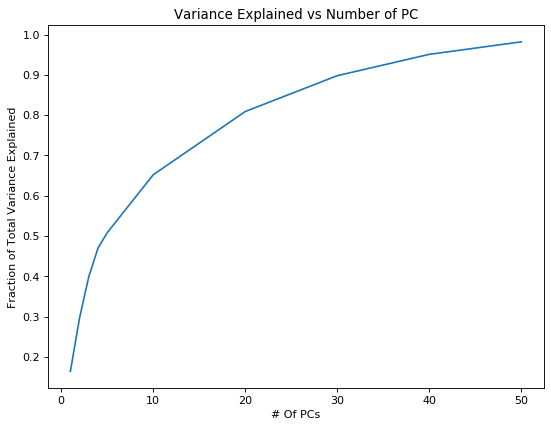

In [134]:
def P1():
    """Breaks data into principal components and shows how much variance is 
       explained by the first 50 components"""
    from matplotlib.pyplot import figure
    ks = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]
    variance = []
    for k in ks:
        pca = PCA(n_components=k)
        pca.fit_transform(train_data)
        var_exp = pca.explained_variance_ratio_
        tot_var = round(np.sum(var_exp), 3)
        variance.append(tot_var)
        print(f'The fraction of total variance explained by k = {k} is {tot_var}')
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot( ks, variance)
    plt.ylabel("Fraction of Total Variance Explained")
    plt.xlabel("# Of PCs")
    plt.title("Variance Explained vs Number of PC")
        

P1()

### Part 2:

PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and show as a square scatterplot. Show the positive (poisonous) examples in red and the negative (non-poisonous) examples in green. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

Notes:
* You can use `PCA` to produce a PCA analysis.

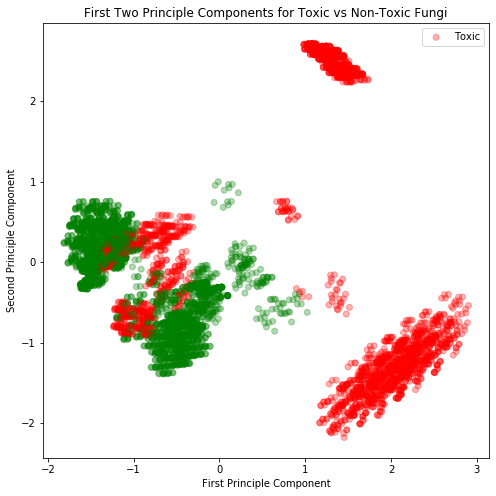

In [153]:
def pc(data, components):
    pca = PCA(n_components=components)
    pca.fit_transform(data)
    return pca.transform(data)
pcs_2 = pc(train_data,2)
def P2():
    plt.figure(figsize=(8,8))
    colors = np.where(train_labels == 1, 'red', 'green')
    labels = np.where(train_labels == 1, "toxic", "Not toxic")
    plt.scatter(pcs_2[:, 0], pcs_2[:, 1], c = colors, alpha = 0.3, cmap = labels)
    plt.xlabel("First Principle Component")
    plt.ylabel("Second Principle Component")
    plt.title("First Two Principle Components for Toxic vs Non-Toxic Fungi")
    plt.legend(["Toxic"])
    plt.show()

P2()

### Part 3:

Fit a k-means cluster model with 6 clusters over the 2d projected data. As in part 2, show as a square scatterplot with the positive (poisonous) examples in red and the negative (non-poisonous) examples in green.  For each cluster, mark the centroid and plot a circle that goes through the cluster's example that is most distant from the centroid.

Notes:
* You can use `KMeans` to produce a k-means cluster analysis.
* You can use `linalg.norm` to determine distance (dissimilarity) between observations.

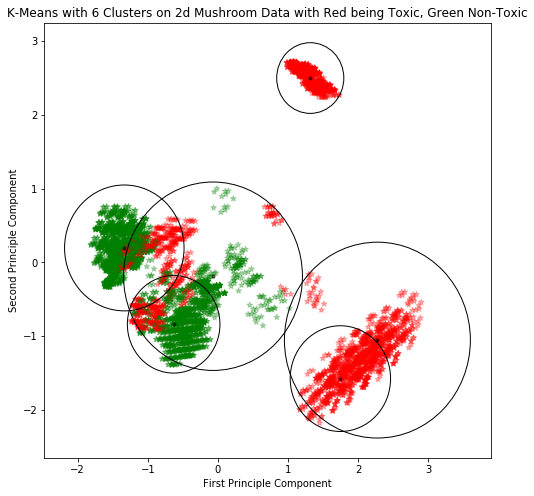

In [154]:
def P3():
    def k_means(data_2d, clusters):
        "Runs Kmeans algorithm on 2d data"
        kmeans = KMeans(n_clusters=clusters).fit(data_2d)
        pred = kmeans.predict(data_2d)
        return kmeans.labels_, kmeans.cluster_centers_, pred
    labels, centroids, pred = k_means(pcs_2, 6)
    max_radius = []
    for i in range(6): #uses the l-2 norm to find the max distance between centroid and outer layer of cluster
        center = centroids[i]
        points = pcs_2[pred == i]
        max_dist = 0
        for p in points:
            dist = np.linalg.norm(p-center)
            if dist > max_dist:
                max_dist = dist
        max_radius.append(max_dist)
    #make figure
    fig, ax = plt.subplots(figsize=(8,8))
    #plot graph from previous part
    colors = np.where(train_labels == 1, 'red', 'green')
    plt.scatter(pcs_2[:, 0], pcs_2[:, 1], c = colors, alpha = 0.3, marker="*")
    for i, rad in enumerate(max_radius):
        plt.scatter(centroids[i, 0], centroids[i,1], c='black', s = 10, alpha = 0.5)
        circle = plt.Circle(centroids[i], radius=rad, fill = False)
        ax.add_patch(circle)
    ax.set_title("K-Means with 6 Clusters on 2d Mushroom Data with Red being Toxic, Green Non-Toxic")
    ax.set_xlabel("First Principle Component")
    ax.set_ylabel("Second Principle Component")      
P3()

### Part 4:

Fit Gaussian mixture models for the positive (poisonous) examples in your 2d projected data. Vary the number of mixture components from 1 to 4 and the covariance matrix type 'spherical', 'diag', 'tied', 'full' (that's 16 models).  Show square plots of the estimated density contours presented in a 4x4 grid - one row each for a number of mixture components and one column each for a convariance matrix type.  

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* You can use `contour` in combination with other methods to plot contours, like in this example: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py
* You can use `contour` without the `norm` and `levels` parameters. 

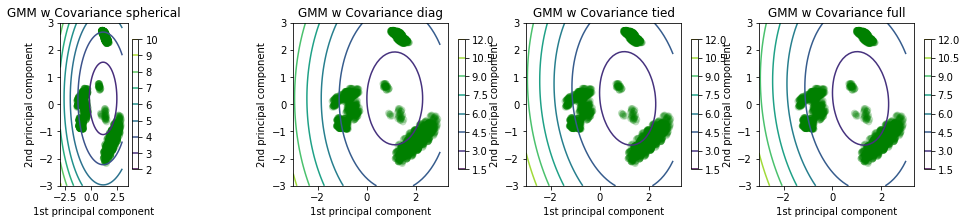

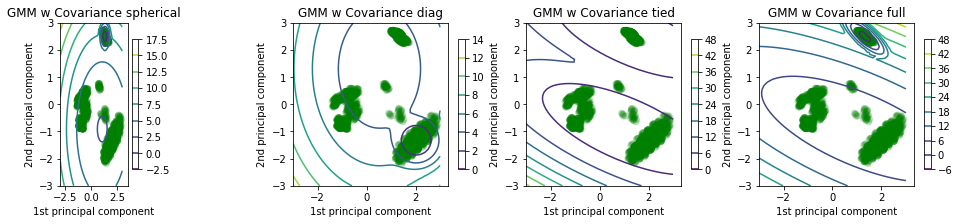

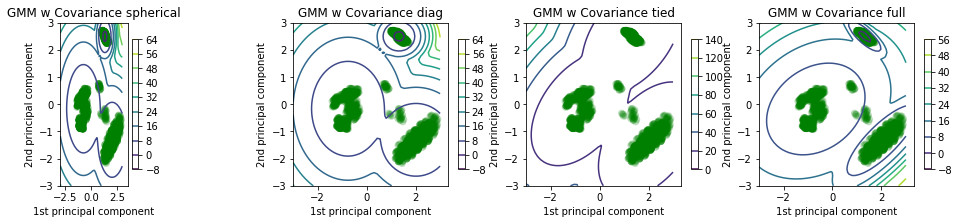

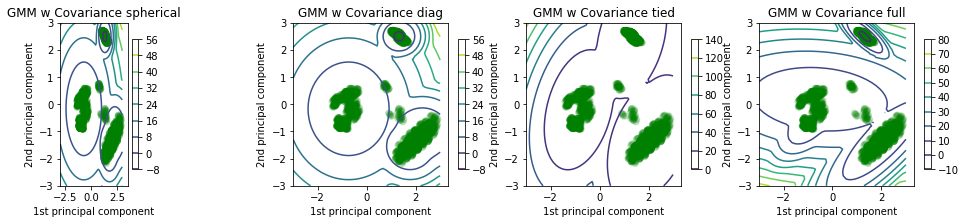

In [157]:
def P4():
    "Plots 16*16 grid of gaussian mixture models on the poisonous mushrooms"
    #covs = ['spherical', 'tied', 'diag', 'full']
    def plot_gauss(X_2D, labels, comp, covariance):
        plt.figure(figsize = (4*len(covariance), 3))
        for i,cov in enumerate(covariance):
            gm = GaussianMixture(n_components=comp, covariance_type=cov)
            data = X_2D[labels==1]
            gm.fit(data) #filters to just toxic mushrooms
            x = np.linspace(-3.0, 3.0) #scikit learn code on contour plot
            y = np.linspace(-3.0, 3.0)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -gm.score_samples(XX)
            Z = Z.reshape(X.shape)
            ax = plt.subplot(1, len(cov), i+1)
            CS = plt.contour(X, Y, Z)
            CB = plt.colorbar(CS, shrink=0.8, extend='both')
            cols = np.where(labels == 1, 'green', 'red')
            plt.scatter(data[:,0], data[:,1], alpha = 0.25, s = 50, c = "green",
                        edgecolor='')
            plt.title(f'GMM w Covariance {cov}')
            plt.xlabel("1st principal component")
            plt.ylabel("2nd principal component")
            plt.axis('tight')
    for comp in range(1, 5):
        plot_gauss(pcs_2, train_labels, comp, ['spherical', 'diag', 'tied', 'full'])
        

P4()

### Part 5:

Fit two Gaussian mixture models, one for the positive examples and one for the negative examples in your 2d projected data. Use 4 mixture components and full convariance for each model.  Predict the test example labels by picking the labels corresponding to the larger of the two models' probabilities.  What is the accuracy of you predictions on the test data?

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* You can use `GaussianMixture`'s `score_samples` method to find the probabilities.

In [138]:
def gauss_mm(components, covar_type, train_data, test_data):
    "Fits "
    gmm = GaussianMixture(n_components=components, covariance_type=covar_type, random_state=12345)
    gmm.fit(train_data)
    #predict = gmm.predict(test_data)
    return gmm.score_samples(test_data)
def P5():
    """Fits two Gaussian mixture models, one on the positive examples and one on the negative examples. 
       It uses four mixture components and full covariance for each model"""
    #Conduct PCA on Train data and on test
    pca = PCA(n_components=2)
    # transform train and test data
    pcs_2_train = pca.fit_transform(train_data) #fits the train data
    pcs_2_test = pca.transform(test_data) # fits test data
    
    #test_pcs = pc(test_data, 2) #breaks test data into first two principle components, have to use transform otherwise does not work
    
    positive_samples_train = pcs_2_train[train_labels == 1] #subsets the positive examples
    negative_samples_train = pcs_2_train[train_labels == 0] #subsets the negative examples
    #Get first to principle components of test set
    score_samples_pos = gauss_mm(4, "full", positive_samples_train, pcs_2_test)
    score_samples_neg = gauss_mm(4, "full", negative_samples_train, pcs_2_test)
    preds = np.where(score_samples_pos >= score_samples_neg, 1, 0)
    print(f'The accuracy is {100* metrics.accuracy_score(test_labels, preds)}%')  
            

P5()

The accuracy is 95.01779359430606%


### Part 6:

Run a series of experiments to find the Gaussian mixture model that results in the best accuracy with no more than 50 parameters.  Do this by varying the number of PCA components, the number of GMM components, and the covariance type.

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.


* For spherical, diag, and full covariance types:
  * number of parameters = (number of parameters per gmm component * number of gmm components - 1) * number of classes
  * number of parameters per gmm component includes all the means plus all the non-zero, non-duplicated values in the covariance matrix plus the mixing weight
  * Each mixing weight parameter indicates how much to weight a particular gmm component; the -1 above accounts for the fact that the mixing weights must sum to 1, so you do not need to include the last mixing weight as its own parameter


* To calculate the number of parameters for tied covariance type:
  * number of parameters = (number of parameters per class - 1) * number of classes
  * number of parameters per class includes all the means and mixing weights for all the gmm components plus all the non-zero, non-duplicated values in the one shared covariance matrix
  * Each mixing weight parameter indicates how much to weight a particular gmm component; the -1 above accounts for the fact that the mixing weights must sum to 1, so you do not need to include the last mixing weight as its own parameter

In [158]:
def P6():
    import pandas as pd
    pc_range = np.arange(1,15) # ceates range of principle component values
    cov_types = ['spherical', 'tied', 'diag', 'full']
    comps = np.arange(1, 15) #creates range of gaussian mixture components
    for pc in pc_range: #iterate over principle components
        for cov in cov_types: #iterate over covariance types
            for comp in comps:
                pca = PCA(n_components=pc)
                pca_train = pca.fit_transform(train_data)
                pca_train_pos = pca_train[train_labels == 1] #subset to only poisonous
                pca_train_neg = pca_train[train_labels == 0] #subset to only non-toxic
                pca_test = pca.transform(test_data) #transforms to the test data
                if cov == "spherical": #control flow to just spherical
                    p = (pc*comp + comp) * 2 #calculates number of parameters for spherical model
                    if (p < 50):
                        positive_scores_sphere = gauss_mm(comp, cov, pca_train_pos, pca_test)
                        negative_scores_sphere = gauss_mm(comp, cov, pca_train_neg, pca_test)
                        preds_sphere = np.where(positive_scores_sphere >= negative_scores_sphere, 1, 0)
                        print(f'The accuracy for the spherical cov with {pc} Pcs and {comp} components is {100* metrics.accuracy_score(test_labels, preds_sphere)}%')
                        
                elif cov == "tied":
                    p = (pc*comp + pc*(pc+1)/2)*2 #calculates number of parameters for tied model
                    if (p<50):
                        positive_scores_tied = gauss_mm(comp, cov, pca_train_pos, pca_test)
                        negative_scores_tied = gauss_mm(comp, cov, pca_train_neg, pca_test)
                        preds_tied = np.where(positive_scores_tied>= negative_scores_tied, 1, 0)
                        print(f'The accuracy for the tied covariance with {pc} Pcs and {comp} components is {100* metrics.accuracy_score(test_labels, preds_tied)}%')
                elif cov == "diag":
                    p = (pc *comp +pc *comp)*2 #calculates number of parameters for diaganol model
                    if (p<50):
                        positive_scores_diag = gauss_mm(comp, cov, pca_train_pos, pca_test)
                        negative_scores_diag = gauss_mm(comp, cov, pca_train_neg, pca_test)
                        preds_diag = np.where(positive_scores_diag >= negative_scores_diag, 1, 0)
                        print(f'The accuracy for the diagonol covariance with {pc} Pcs and {comp} components is {100* metrics.accuracy_score(test_labels, preds_diag)}%')
                else:
                    p = (pc*comp+pc*(pc+1)/2*comp)*2  #calculates number of parameters for full model
                    if (p<50):
                        positive_scores_full = gauss_mm(comp, cov, pca_train_pos, pca_test)
                        negative_scores_full = gauss_mm(comp, cov, pca_train_neg, pca_test)
                        preds_full = np.where(positive_scores_full >= negative_scores_full, 1, 0)
                        print(f'The accuracy for the full covariance with {pc} Pcs and {comp} components is {100* metrics.accuracy_score(test_labels, preds_full)}%')
             

P6()

The accuracy for the spherical cov with 1 Pcs and 1 components is 84.4306049822064%
The accuracy for the spherical cov with 1 Pcs and 2 components is 89.85765124555161%
The accuracy for the spherical cov with 1 Pcs and 3 components is 90.74733096085409%
The accuracy for the spherical cov with 1 Pcs and 4 components is 91.45907473309609%
The accuracy for the spherical cov with 1 Pcs and 5 components is 91.10320284697508%
The accuracy for the spherical cov with 1 Pcs and 6 components is 90.83629893238434%
The accuracy for the spherical cov with 1 Pcs and 7 components is 90.92526690391459%
The accuracy for the spherical cov with 1 Pcs and 8 components is 90.92526690391459%
The accuracy for the spherical cov with 1 Pcs and 9 components is 90.83629893238434%
The accuracy for the spherical cov with 1 Pcs and 10 components is 91.45907473309609%
The accuracy for the spherical cov with 1 Pcs and 11 components is 91.28113879003558%
The accuracy for the spherical cov with 1 Pcs and 12 components 

The accuracy for the full covariance with 3 Pcs and 1 components is 86.56583629893238%
The accuracy for the full covariance with 3 Pcs and 2 components is 91.01423487544484%
The accuracy for the spherical cov with 4 Pcs and 1 components is 86.29893238434164%
The accuracy for the spherical cov with 4 Pcs and 2 components is 89.1459074733096%
The accuracy for the spherical cov with 4 Pcs and 3 components is 91.19217081850533%
The accuracy for the spherical cov with 4 Pcs and 4 components is 95.72953736654804%
The accuracy for the tied covariance with 4 Pcs and 1 components is 81.67259786476868%
The accuracy for the tied covariance with 4 Pcs and 2 components is 94.7508896797153%
The accuracy for the tied covariance with 4 Pcs and 3 components is 96.97508896797153%
The accuracy for the diagonol covariance with 4 Pcs and 1 components is 84.34163701067615%
The accuracy for the diagonol covariance with 4 Pcs and 2 components is 91.54804270462633%
The accuracy for the diagonol covariance with

### The highest accuracies were a tie between the Spherical Covariance with 7 principle components and 3 Gaussian Mixture components and the Diaganol Covariance with 6 principle components and 2 Gaussian Mixture Components